## <center>It must be not enoght markdowns</center>
<center>But I'll trynna let it stright</center>

### Chapter 1. Collecting

In [4]:
# !pip install albumentations
# !pip install opencv-python
# !pip install labelme

In [5]:
import os
import cv2
import uuid
import time

In [6]:
IMAGE_PATH = os.path.join('data','images')
number_images = 30

In [22]:
cap = cv2.VideoCapture(0)
for imgn in range(number_images):
    print('Scan', imgn)
    ret, frame = cap.read()
    imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    time.sleep(0.4)

cap.release()

Scan 0
Scan 1
Scan 2
Scan 3
Scan 4
Scan 5
Scan 6
Scan 7
Scan 8
Scan 9
Scan 10
Scan 11
Scan 12
Scan 13
Scan 14
Scan 15
Scan 16
Scan 17
Scan 18
Scan 19
Scan 20
Scan 21
Scan 22
Scan 23
Scan 24
Scan 25
Scan 26
Scan 27
Scan 28
Scan 29


Now we need to label these images using labelme

### Chapter 2. Preprocessing
final amound of images is 69.

In [2]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [3]:
images.as_numpy_iterator().next()

b'data\\images\\499faeb5-5f43-11ed-9c66-5c61990e5950.jpg'

In [1]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_img)
# images.as_numpy_iterator().next()

# next used to iterate through out data. Everytime we call .next() we get next element of iterator.
# but use one picture at time is really bothering so we will connect 4 or 3 (idk) images to batches

let's show some of out pictures

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [26]:
for_plot = image_generator.next()

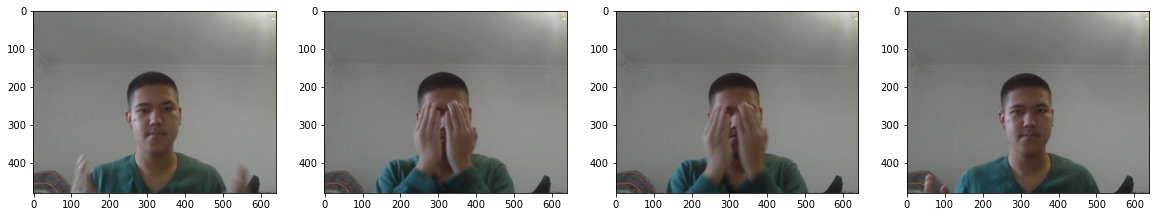

In [27]:
_, ax = plt.subplots(1, 4, figsize=(20, 20))
for i, j in enumerate(for_plot):
    ax[i].imshow(j)

split data to train, test and val

In [37]:
92-64-14-14 == 0

True

we made 3 folders with images. now we'll pair images with their labels.

In [2]:
import os

In [3]:
for fname in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', fname, 'images')):
        filename = file.split('.')[0]+'.json'
        for_search = os.path.join('data', 'labels', filename)

        if os.path.exists(for_search):
            new_path = os.path.join('data', fname, 'labels', filename)
            os.replace(for_search, new_path)

omg it works!!!! now we will apply argumentation

### Chapter 3. Albumentation.

In [2]:
import albumentations as alb
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
augmentor = alb.Compose([ 
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.RandomGamma(p=0.2),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RGBShift(p=0.2)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [4]:
img = cv2.imread(os.path.join('data', 'train', 'images', '4bf578e0-5f43-11ed-927d-5c61990e5950.jpg'))

In [5]:
with open(os.path.join('data', 'train', 'labels', '4bf578e0-5f43-11ed-927d-5c61990e5950.json'), 'r') as f:
    label = json.load(f)

In [6]:
label['shapes'][0]['label'], label['shapes'][0]['points']

('face',
 [[234.2512077294686, 141.44927536231884],
  [415.4106280193237, 338.5507246376812]])

take coordinates 

In [7]:
coords = [0,0,0,0]
coords[0] = min(label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][1][0])
coords[1] = min(label['shapes'][0]['points'][0][1], label['shapes'][0]['points'][1][1])
coords[2] = max(label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][1][0])
coords[3] = max(label['shapes'][0]['points'][0][1], label['shapes'][0]['points'][1][1])

In [8]:
coords

[234.2512077294686, 141.44927536231884, 415.4106280193237, 338.5507246376812]

In [9]:
img.shape

(480, 640, 3)

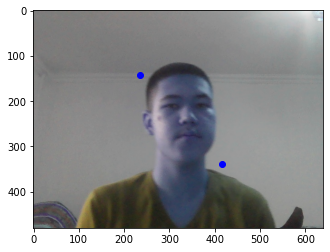

In [10]:
plt.imshow(img)
plt.scatter(coords[0], coords[1], c='blue')
plt.scatter(coords[2], coords[3], c='blue')


In [11]:
coords = np.divide(coords, [640,480,640,480])
coords

array([0.36601751, 0.29468599, 0.64907911, 0.70531401])

now we'll connect all stuff together.

In [12]:
augmented = augmentor(image=img, class_labels=['face'], bboxes=[coords])

In [13]:
augmented.keys()

dict_keys(['image', 'class_labels', 'bboxes'])

### Chapter 4. Pipeline

In [3]:
import albumentations as alb
import cv2
import json
import numpy as np
import os
import matplotlib.pyplot as plt

In [16]:
augmentor = alb.Compose([ 
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.RandomGamma(p=0.2),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RGBShift(p=0.2)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [17]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords = [0,0,0,0]
            coords[0] = min(label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][1][0])
            coords[1] = min(label['shapes'][0]['points'][0][1], label['shapes'][0]['points'][1][1])
            coords[2] = max(label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][1][0])
            coords[3] = max(label['shapes'][0]['points'][0][1], label['shapes'][0]['points'][1][1])
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

lets go ahead. for notice: I didn't write the code under this cell. I copied it so I want you to check the code out before you leave this notebook.

In [18]:
import tensorflow as tf

In [59]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [60]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [61]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

Lemme go and do the same thing with the labels

In [62]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [63]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [64]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [65]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

combine

In [66]:
len(train_labels), len(train_images)

(3840, 3840)

In [67]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [68]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [69]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [70]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

you, shreck this out

In [71]:
data_samples = train.as_numpy_iterator()

In [72]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


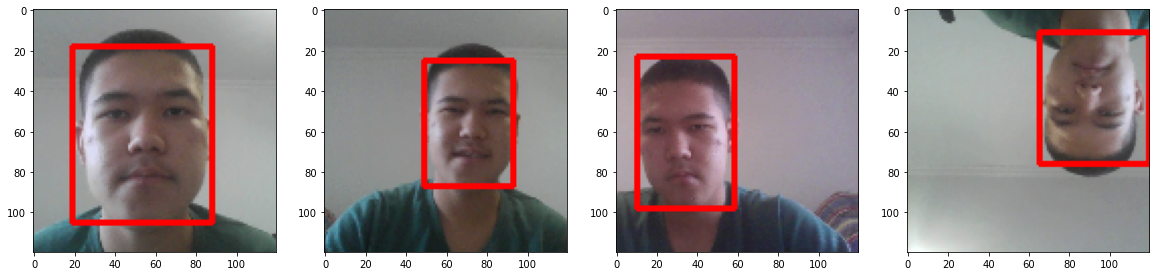

In [73]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

OMG!!!! HE'S LIFE! LIIIIIFFFFEEEE!

## CHAPTER 7 DEEP LEARNING

In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [79]:
vgg = VGG16(include_top=False)
vgg.input_shape

58889256/58889256 [==============================] - 85s 1us/step


(None, None, None, 3)

In [80]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

build model

In [93]:
def build_model():
    input_l = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_l)

    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regresoin1 = Dense(2048, activation='relu')(f2)
    regresoin2 = Dense(4, activation='sigmoid')(regresoin1)

    return Model(inputs=input_l, outputs=[class2, regresoin2])

In [102]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.241 , 0.255 , 0.6265, 0.7734],
        [0.2307, 0.3154, 0.6816, 0.9756],
        [0.135 , 0.2382, 0.4946, 0.7363],
        [0.446 , 0.267 , 0.8057, 0.765 ],
        [0.2246, 0.2651, 0.654 , 0.7656],
        [0.2257, 0.2031, 0.616 , 0.7397],
        [0.1733, 0.3103, 0.6113, 0.8096],
        [0.1753, 0.1453, 0.4963, 0.5693]], dtype=float16))

In [94]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_12[0][0]']               
                                512)                                                              
                                                                                                  
 global_max_pooling2d_8 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                                

In [97]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [99]:
facetracker.predict(X)

1/1 [==============================] - 1s 623ms/step


[array([[0.56434494],
        [0.5749014 ],
        [0.5437753 ],
        [0.58036727],
        [0.58303136],
        [0.5460957 ],
        [0.5773176 ],
        [0.46357226]], dtype=float32),
 array([[0.6804262 , 0.42888847, 0.6247488 , 0.3518946 ],
        [0.6735322 , 0.43624428, 0.6247919 , 0.3680748 ],
        [0.6421845 , 0.39954868, 0.61445254, 0.34618878],
        [0.54593956, 0.42488265, 0.624685  , 0.36721426],
        [0.59861934, 0.46643877, 0.58095443, 0.3521474 ],
        [0.66285336, 0.42332882, 0.5842893 , 0.3444904 ],
        [0.5262291 , 0.40532547, 0.574975  , 0.40521643],
        [0.46427613, 0.39775288, 0.5822764 , 0.39858305]], dtype=float32)]

now we need optimazer and 2 loss funcitons 

we need to find our learning decay

### $lr_{decay} = \cfrac{\frac{1}{0.75} - 1}{\text{batch per epoch}}$

In [103]:
batch_per_epoch = len(train)
lr_decay = (1/0.75 - 1) / batch_per_epoch

In [105]:
lr_decay

0.0006944444444444443

```
~0.0006 -> learning rate will be 
~0.0001
🫠
```

In [107]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

now we'll implement localization loss. It is like the distance between two objects

<center><img src='https://i.stack.imgur.com/nQuCg.jpg'></center>

In [108]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [110]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regretoin_loss = localization_loss

### Chapter 8. Model itself.

In [114]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs):  # If you skip it. model.predict will not work bro 🙃
        return self.model(X, **kwargs)

In [115]:
model = FaceTracker(facetracker)

In [116]:
model.compile(opt, class_loss, regretoin_loss)

The most important part

In [117]:
logdir = 'logs'

In [118]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [120]:
model.fit(train, epochs=10, validation_data=val, callbacks=[tensorflow_callback])

Epoch 1/10
480/480 [==============================] - 1394s 3s/step - total_loss: 0.1002 - class_loss: 0.0204 - regress_loss: 0.0900 - val_total_loss: 0.0676 - val_class_loss: 5.0100e-05 - val_regress_loss: 0.0676
Epoch 2/10
480/480 [==============================] - 1355s 3s/step - total_loss: 0.0216 - class_loss: 9.0730e-05 - regress_loss: 0.0216 - val_total_loss: 0.0586 - val_class_loss: 7.7264e-06 - val_regress_loss: 0.0586
Epoch 3/10
480/480 [==============================] - 1326s 3s/step - total_loss: 0.0145 - class_loss: 3.6055e-05 - regress_loss: 0.0145 - val_total_loss: 0.5691 - val_class_loss: 0.5216 - val_regress_loss: 0.3083
Epoch 4/10
337/480 [====================>.........] - ETA: 17:27 - total_loss: 0.0107 - class_loss: 2.1403e-05 - regress_loss: 0.0107

KeyboardInterrupt: 

we cannot plot the results, cause it is difficult to print history of hole train i we didn't train model to the end

In [122]:
test_data = test.as_numpy_iterator()

In [128]:
test_sample = test_data.next()

In [136]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 665ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


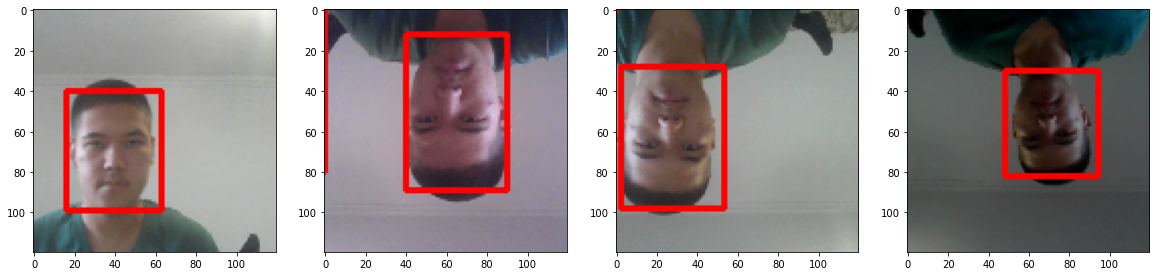

In [137]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## OMGGGGG It works!

In [6]:


from tensorflow.keras.models import load_model




In [ ]:
facetracker.save('facetracker.h5')

In [7]:
facetracker = load_model('facetracker.h5')

Now lets go ahead and make it work!

In [8]:
import cv2

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 143ms/step


In [9]:
import tensorflow as tf
import numpy as np